# Assignment-2B-Task3_streaming_application
## DISHI JAIN
### 30759307


## 3.1

In [57]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark import SparkConf
from pyspark.sql.functions import udf, array
import time
from pyspark.ml import PipelineModel
import datetime

import datetime as dt
from  pyspark.sql.functions import abs
from pyspark.sql.functions import lit

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[2]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Spark Streaming"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone", "UTC")

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')


In [58]:
from pyspark.sql import functions as sf
from pyspark.sql.functions import udf, array
import time
from pyspark.ml import PipelineModel
import datetime

## 3.2

In [59]:
#dataframe generation for process
topic_process = "process_final199"
df_process = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic_process) \
    .load()

In [60]:
#dataframe generation for memory
topic_memory = "memory_final199"
df_memory = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic_memory) \
    .load()

In [61]:
#casting to strings of key and value

df_process = df_process.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [62]:
#casting to strings of key and value
df_memory = df_memory.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [63]:
#Define the schema for the structured datastream received
schema_process = ArrayType(StructType([    
    StructField('sequence', IntegerType(), True), 
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True),            
    StructField('TRUN', IntegerType(), True), 
    StructField('TSLPI', IntegerType(), True),
    StructField('TSLPU', IntegerType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', IntegerType(), True), 
    StructField('PRI', IntegerType(), True),
    StructField('RTPR', IntegerType(), True),
    StructField('CPUNR', IntegerType(), True), 
    StructField('Status', StringType(), True),
    StructField('EXC', IntegerType(), True),
    StructField('State', StringType(), True), 
    StructField('CPU', FloatType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', IntegerType(), True)

]))

In [64]:
#Define the schema for the structured datastream received
schema_memory = ArrayType(StructType([    
    StructField('sequence', IntegerType(), True), 
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True),            
    StructField('MINFLT', StringType(), True), 
    StructField('MAJFLT', StringType(), True),
    StructField('VSTEXT', StringType(), True),
    StructField('VSIZE', FloatType(), True), 
    StructField('RSIZE', StringType(), True),
    StructField('VGROW', StringType(), True),
    StructField('RGROW', StringType(), True), 
    StructField('MEM', FloatType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', IntegerType(), True)
]))

In [65]:
#correcting the dataframes nesting

df_process = df_process.select(F.from_json(F.col("value").cast("string"), schema_process).alias('parsed_value'))
df_process = df_process.select(F.explode(F.col("parsed_value")).alias('unnested_value'))  


df_process.printSchema()

root
 |-- unnested_value: struct (nullable = true)
 |    |-- sequence: integer (nullable = true)
 |    |-- machine: integer (nullable = true)
 |    |-- PID: integer (nullable = true)
 |    |-- TRUN: integer (nullable = true)
 |    |-- TSLPI: integer (nullable = true)
 |    |-- TSLPU: integer (nullable = true)
 |    |-- POLI: string (nullable = true)
 |    |-- NICE: integer (nullable = true)
 |    |-- PRI: integer (nullable = true)
 |    |-- RTPR: integer (nullable = true)
 |    |-- CPUNR: integer (nullable = true)
 |    |-- Status: string (nullable = true)
 |    |-- EXC: integer (nullable = true)
 |    |-- State: string (nullable = true)
 |    |-- CPU: float (nullable = true)
 |    |-- CMD: string (nullable = true)
 |    |-- ts: integer (nullable = true)



In [66]:
#correcting the dataframes nesting

df_memory = df_memory.select(F.from_json(F.col("value").cast("string"), schema_memory).alias('parsed_value'))
df_memory = df_memory.select(F.explode(F.col("parsed_value")).alias('unnested_value'))  


df_memory.printSchema()

root
 |-- unnested_value: struct (nullable = true)
 |    |-- sequence: integer (nullable = true)
 |    |-- machine: integer (nullable = true)
 |    |-- PID: integer (nullable = true)
 |    |-- MINFLT: string (nullable = true)
 |    |-- MAJFLT: string (nullable = true)
 |    |-- VSTEXT: string (nullable = true)
 |    |-- VSIZE: float (nullable = true)
 |    |-- RSIZE: string (nullable = true)
 |    |-- VGROW: string (nullable = true)
 |    |-- RGROW: string (nullable = true)
 |    |-- MEM: float (nullable = true)
 |    |-- CMD: string (nullable = true)
 |    |-- ts: integer (nullable = true)



In [67]:
#renaming the columns
df_process_formatted = df_process.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.TRUN").alias("TRUN"),
                    F.col("unnested_value.TSLPI").alias("TSLPI"),
                    F.col("unnested_value.TSLPU").alias("TSLPU"),
                    F.col("unnested_value.POLI").alias("POLI"),
                    F.col("unnested_value.NICE").alias("NICE"),
                    F.col("unnested_value.PRI").alias("PRI"),
                    F.col("unnested_value.RTPR").alias("RTPR"),
                    F.col("unnested_value.CPUNR").alias("CPUNR"),
                    F.col("unnested_value.Status").alias("Status"),
                    F.col("unnested_value.EXC").alias("EXC"),
                    F.col("unnested_value.State").alias("State"),
                    F.col("unnested_value.CPU").alias("CPU"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [68]:
#renaming the columns
df_memory_formatted = df_memory.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.MINFLT").alias("MINFLT"),
                    F.col("unnested_value.MAJFLT").alias("MAJFLT"),
                    F.col("unnested_value.VSTEXT").alias("VSTEXT"),
                    F.col("unnested_value.VSIZE").alias("VSIZE"),
                    F.col("unnested_value.RSIZE").alias("RSIZE"),
                    F.col("unnested_value.VGROW").alias("VGROW"),
                    F.col("unnested_value.RGROW").alias("RGROW"),
                    F.col("unnested_value.MEM").alias("MEM"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [69]:
df_process_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



In [70]:
df_memory_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



## 3.3

In [71]:
#udf for NICE and PRI calculation

udf_for_nice = udf(lambda val: val - 120, IntegerType())
df_process_formatted = df_process_formatted.withColumn("NICE", udf_for_nice("PRI"))

In [72]:
#UDF for handling of M G K and spaces in memory

udf_for_m = udf(lambda val: str(float(val.replace("M", ""))*1000000) if "M" in val else val, StringType())

df_memory_formatted = df_memory_formatted.withColumn("MINFLT", udf_for_m("MINFLT"))
df_memory_formatted = df_memory_formatted.withColumn("MAJFLT", udf_for_m("MAJFLT"))
df_memory_formatted = df_memory_formatted.withColumn("VSTEXT", udf_for_m("VSTEXT"))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", udf_for_m("RSIZE"))
df_memory_formatted = df_memory_formatted.withColumn("VGROW", udf_for_m("VGROW"))
df_memory_formatted = df_memory_formatted.withColumn("RGROW", udf_for_m("RGROW"))



udf_for_k = udf(lambda val: str(float(val.replace("K", ""))*1000) if "K" in val else val, StringType())
df_memory_formatted = df_memory_formatted.withColumn("MINFLT", udf_for_k("MINFLT"))
df_memory_formatted = df_memory_formatted.withColumn("MAJFLT", udf_for_k("MAJFLT"))
df_memory_formatted = df_memory_formatted.withColumn("VSTEXT", udf_for_k("VSTEXT"))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", udf_for_k("RSIZE"))
df_memory_formatted = df_memory_formatted.withColumn("VGROW", udf_for_k("VGROW"))
df_memory_formatted = df_memory_formatted.withColumn("RGROW", udf_for_k("RGROW"))

udf_for_space = udf(lambda val: val.replace(" ", "") if " " in val else val)
df_memory_formatted = df_memory_formatted.withColumn("MINFLT", udf_for_space("MINFLT"))
df_memory_formatted = df_memory_formatted.withColumn("MAJFLT", udf_for_space("MAJFLT"))
df_memory_formatted = df_memory_formatted.withColumn("VSTEXT", udf_for_space("VSTEXT"))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", udf_for_space("RSIZE"))
df_memory_formatted = df_memory_formatted.withColumn("VGROW", udf_for_space("VGROW"))
df_memory_formatted = df_memory_formatted.withColumn("RGROW", udf_for_space("RGROW"))


df_memory_formatted = df_memory_formatted.withColumn("MINFLT", df_memory_formatted["MINFLT"].cast(IntegerType()))
df_memory_formatted = df_memory_formatted.withColumn("MAJFLT", df_memory_formatted["MAJFLT"].cast(IntegerType()))
df_memory_formatted = df_memory_formatted.withColumn("VSTEXT", df_memory_formatted["VSTEXT"].cast(IntegerType()))
df_memory_formatted = df_memory_formatted.withColumn("RSIZE", df_memory_formatted["RSIZE"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("VGROW", df_memory_formatted["VGROW"].cast(FloatType()))
df_memory_formatted = df_memory_formatted.withColumn("RGROW", df_memory_formatted["RGROW"].cast(FloatType()))




## 3.4

In [73]:
# udf for creating ebent_time and CMD_PID for memory and process

udf_for_concat = udf(lambda val: str(val[0] + "_" + val[1]), StringType())
udf_for_event = udf(lambda val: datetime.datetime.strptime(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(val)),'%Y-%m-%d %H:%M:%S'),TimestampType())

df_process_formatted = df_process_formatted.withColumn("CMD_PID", udf_for_concat(array('CMD', 'PID')))
df_process_formatted = df_process_formatted.withColumn("event_time", udf_for_event("ts"))


df_memory_formatted = df_memory_formatted.withColumn("CMD_PID", udf_for_concat(array('CMD', 'PID')))
df_memory_formatted = df_memory_formatted.withColumn("event_time", udf_for_event("ts"))


## 3.5


In [74]:
#parquet process
query_file_sink_pro = df_process_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process.parquet")\
        .option("checkpointLocation", "process.parquet/checkpoint")\
        .start()

In [75]:
query_file_sink_pro.stop()

In [76]:
#parquet process
query_file_sink_mem = df_memory_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "memory.parquet")\
        .option("checkpointLocation", "memory.parquet/checkpoint")\
        .start()


In [77]:
query_file_sink_mem.stop()

## 3.6

In [78]:
#loading the given models for memory and process
pipelinemodel_mem = PipelineModel.load('memory_pipeline_model')
pipelinemodel_pro = PipelineModel.load('process_pipeline_model')


In [79]:
#transforming the dataframes to get prediction values
predictions_process = pipelinemodel_pro.transform(df_process_formatted)
predictions_memory = pipelinemodel_mem.transform(df_memory_formatted)


## 3.7 - A

In [80]:
#filtering to get only rows with attacks as yes

attack_predictions_memory = predictions_memory.filter(predictions_memory.prediction == 1.0)
attack_predictions_process = predictions_process.filter(predictions_process.prediction == 1.0)



In [81]:
#getting count of predictions based on machine and event_time
windowedCounts_mem = attack_predictions_memory \
    .withWatermark("event_time", "120 seconds") \
    .groupBy(window(attack_predictions_memory.event_time, "120 seconds"), 'machine')\
    .agg(F.count("sequence").alias("total"))\
    .select("window","machine", "total")

In [82]:
#getting count of predictions based on machine and event_time
windowedCounts_pro = attack_predictions_process \
    .withWatermark("event_time", "120 seconds") \
    .groupBy(window(attack_predictions_process.event_time, "120 seconds"), 'machine')\
    .agg(F.count("sequence").alias("total"))\
    .select("window","machine", "total")

In [83]:
#query for memory
query_mem = windowedCounts_mem \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("query_for_mem") \
    .trigger(processingTime='5 seconds') \
    .option("truncate","false")\
    .start()

In [49]:
query_mem.stop()

In [84]:
#query for process
query_pro = windowedCounts_pro \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("query_for_pro") \
    .trigger(processingTime='5 seconds') \
    .option("truncate","false")\
    .start()

In [85]:
query_pro.stop()

## 3.7 - B

In [86]:
#renaming the columns as required after joining

renamed_mem = attack_predictions_memory.withColumnRenamed("ts","ts_memory").withColumnRenamed("CMD_PID","CMD_PID_memory").withColumnRenamed("prediction","prediction_memory").withColumnRenamed("machine","machine_memory").withColumnRenamed("event_time","event_time_memory")
renamed_mem.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine_memory: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: float (nullable = true)
 |-- VGROW: float (nullable = true)
 |-- RGROW: float (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts_memory: integer (nullable = true)
 |-- CMD_PID_memory: string (nullable = true)
 |-- event_time_memory: timestamp (nullable = true)
 |-- tmp_CMD: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CMD_vec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction_memory: double (nullable = false)



In [87]:
#renaming the columns as required after joining

renamed_pro = attack_predictions_process.withColumnRenamed("ts","ts_process").withColumnRenamed("CMD_PID","CMD_PID_process").withColumnRenamed("prediction","prediction_process").withColumnRenamed("machine","machine_process").withColumnRenamed("event_time","event_time_process")
renamed_pro.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine_process: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts_process: integer (nullable = true)
 |-- CMD_PID_process: string (nullable = true)
 |-- event_time_process: timestamp (nullable = true)
 |-- POLI_idx: double (nullable = false)
 |-- Status_idx: double (nullable = false)
 |-- State_idx: double (nullable = false)
 |-- POLI_vec: vector (nullable = true)
 |-- Status_vec: vector (nullable = true)
 |-- State_vec: vector (nullable = true)
 

In [88]:
#joining the dataframes
mem_pro_join = renamed_mem.join(renamed_pro)


In [89]:
#filtering based on time stamps difference
final_join = mem_pro_join.filter(abs(mem_pro_join.ts_process - mem_pro_join.ts_memory) <= 30)


In [90]:

final_join_df = final_join.withColumn("ProcessingTime",lit(dt.datetime.utcnow()))

## 3.8

In [91]:
#function for plotting graph
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.title.set_text('Time Vs Value')
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


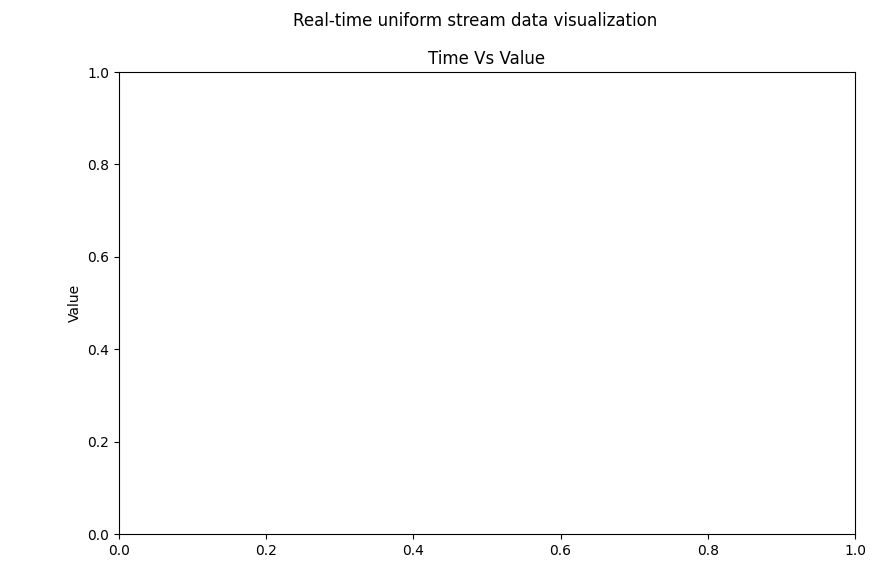

KeyboardInterrupt: 

In [92]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    #filtering data based on machine values from above created query for memory
    mem_4 = spark.sql("select * from query_for_mem where machine = 4").toPandas()
    mem_5 = spark.sql("select * from query_for_mem where machine = 5").toPandas()
    mem_6 = spark.sql("select * from query_for_mem where machine = 6").toPandas()
    mem_7 = spark.sql("select * from query_for_mem where machine = 7").toPandas()
    mem_8 = spark.sql("select * from query_for_mem where machine = 8").toPandas()
    
    
    win_4 = mem_4['window'].to_list()
    tot_4 = mem_4['total'].to_list()
    
    win_5 = mem_5['window'].to_list()
    tot_5 = mem_5['total'].to_list()
    
    win_6 = mem_6['window'].to_list()
    tot_6 = mem_6['total'].to_list()
    
    win_7 = mem_7['window'].to_list()
    tot_7 = mem_7['total'].to_list()
    
    win_8 = mem_8['window'].to_list()
    tot_8 = mem_8['total'].to_list()
    ax.clear()
    
    ax.plot(win_4, tot_4, label='M4')
    ax.plot(win_5, tot_5, label='M5')
    ax.plot(win_6, tot_6, label='M6')
    ax.plot(win_7, tot_7, label='M7')
    ax.plot(win_8, tot_8, label='M8')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    legen = ax.legend()
    fig.canvas.draw()
    
    time.sleep(600)

In [ ]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    #filtering data based on machine values from above created query for process
    mem_4 = spark.sql("select * from query_for_pro where machine = 4").toPandas()
    mem_5 = spark.sql("select * from query_for_pro where machine = 5").toPandas()
    mem_6 = spark.sql("select * from query_for_pro where machine = 6").toPandas()
    mem_7 = spark.sql("select * from query_for_pro where machine = 7").toPandas()
    mem_8 = spark.sql("select * from query_for_pro where machine = 8").toPandas()
    
    
    win_4 = mem_4['window'].to_list()
    tot_4 = mem_4['total'].to_list()
    
    win_5 = mem_5['window'].to_list()
    tot_5 = mem_5['total'].to_list()
    
    win_6 = mem_6['window'].to_list()
    tot_6 = mem_6['total'].to_list()
    
    win_7 = mem_7['window'].to_list()
    tot_7 = mem_7['total'].to_list()
    
    win_8 = mem_8['window'].to_list()
    tot_8 = mem_8['total'].to_list()
    ax.clear()
    
    ax.plot(win_4, tot_4, label='M4')
    ax.plot(win_5, tot_5, label='M5')
    ax.plot(win_6, tot_6, label='M6')
    ax.plot(win_7, tot_7, label='M7')
    ax.plot(win_8, tot_8, label='M8')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    legen = ax.legend()
    fig.canvas.draw()
    
    time.sleep(600)